# Intelligibilité

## Import modules

In [41]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import product_sub.settings as stg
from product_sub.infrastructure.eco_social import EcoSocioContext
from product_sub.infrastructure.bank_campaign import MarketingCampaign
from product_sub.infrastructure.dataset_builder import DatasetBuilder
from product_sub.domain.data_cleaning import CatImputer, NumImputer
from product_sub.domain.feature_creator import CategoricalCreatorFromNumerical, CategoricalFeatureCreator
from product_sub.domain.feature_encoder import FrequencyEncoder, OneHotEncoder

from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.compose import make_column_selector as selector
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.pipeline import FeatureUnion, Pipeline, make_pipeline, make_union
from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV
from sklearn.metrics import classification_report

from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier

from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import AdaBoostClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier

import pdpbox

## Construction pipeline

In [6]:
dataset_merged = DatasetBuilder("data.csv", "socio_eco.csv").create_dataset()
RANDOM_STATE = 89
cv = StratifiedKFold(shuffle=True, n_splits=5, random_state=RANDOM_STATE)

X = dataset_merged.drop(columns=stg.COL_RAW_SUBSCRIPTION)
y = dataset_merged[stg.COL_RAW_SUBSCRIPTION].values
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=RANDOM_STATE)

numeric_transformer = Pipeline(steps=[("num_imputer", NumImputer()),
                                      ("create_categorical",CategoricalCreatorFromNumerical(stg.DICT_TO_CREATE_COLS)),
                                      ("scaler", MinMaxScaler())])

categorical_transformer = Pipeline(steps=[("cat_imputer", CatImputer()),
                                          ("cat_creator", CategoricalFeatureCreator()),
                                          ("freq_encoder", FrequencyEncoder(stg.COLS_TO_FREQ_ENCODE)),
                                          ("one_hot_encoder", OneHotEncoder([stg.COL_RAW_JOB]))])

preprocessor = ColumnTransformer(transformers=[("num", numeric_transformer, selector(dtype_exclude="category")),
                                               ("cat", categorical_transformer, selector(dtype_include="category"))])

## Construction graphique MDI

In [7]:
def plot_feature_importance(importance,names,model_type):

    #Create arrays from feature importance and feature names
    feature_importance = np.array(importance)
    feature_names = np.array(names)

    #Create a DataFrame using a Dictionary
    data={'feature_names':feature_names,'feature_importance':feature_importance}
    fi_df = pd.DataFrame(data)

    #Sort the DataFrame in order decreasing feature importance
    fi_df.sort_values(by=['feature_importance'], ascending=False,inplace=True)

    #Define size of bar plot
    plt.figure(figsize=(10,8))
    #Plot Searborn bar chart
    sns.barplot(x=fi_df['feature_importance'], y=fi_df['feature_names'])
    #Add chart labels
    plt.title(model_type + 'FEATURE IMPORTANCE')
    plt.xlabel('FEATURE IMPORTANCE')
    plt.ylabel('FEATURE NAMES')

# feature_importances

## DecisionTree Classifier

       MONTH  WEEKDAY  is_first_campaign  nb_contact_last_campaign_inf_4  \
11215      6        4                  1                               0   
31128      4        3                  1                               0   
28041      2        0                  1                               0   

       nb_contact_last_campaign_inf_8  nb_contact_last_campaign_inf_12  \
11215                               0                                0   
31128                               0                                0   
28041                               0                                0   

       nb_contact_last_campaign_sup_12  
11215                                0  
31128                                0  
28041                                0  


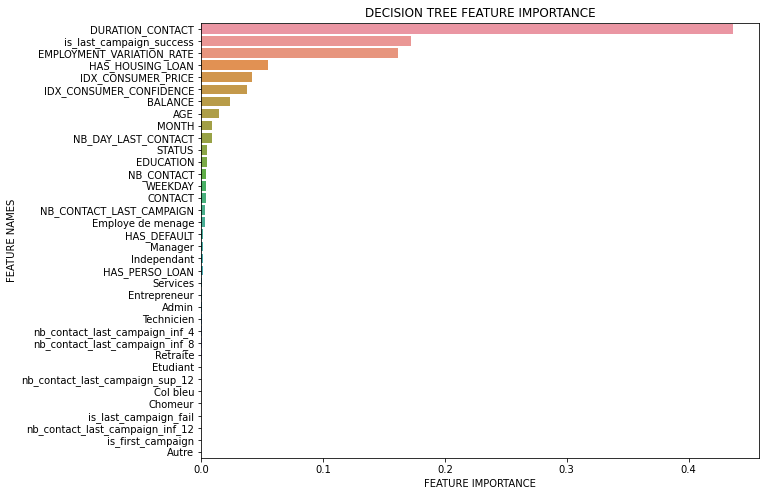

In [51]:
dtc = Pipeline(steps=[('preprocessor' , preprocessor),
                      ('dtc', DecisionTreeClassifier(criterion='gini', splitter='best',max_depth=8,
                                                     min_samples_split=2, min_samples_leaf=1))])

dtc = dtc.fit(X_train,y_train)
plot_feature_importance(dtc[1].feature_importances_,stg.FINAL_COLUMNS,'DECISION TREE ')

## RandomForest Classifier

       MONTH  WEEKDAY  is_first_campaign  nb_contact_last_campaign_inf_4  \
11215      6        4                  1                               0   
31128      4        3                  1                               0   
28041      2        0                  1                               0   

       nb_contact_last_campaign_inf_8  nb_contact_last_campaign_inf_12  \
11215                               0                                0   
31128                               0                                0   
28041                               0                                0   

       nb_contact_last_campaign_sup_12  
11215                                0  
31128                                0  
28041                                0  


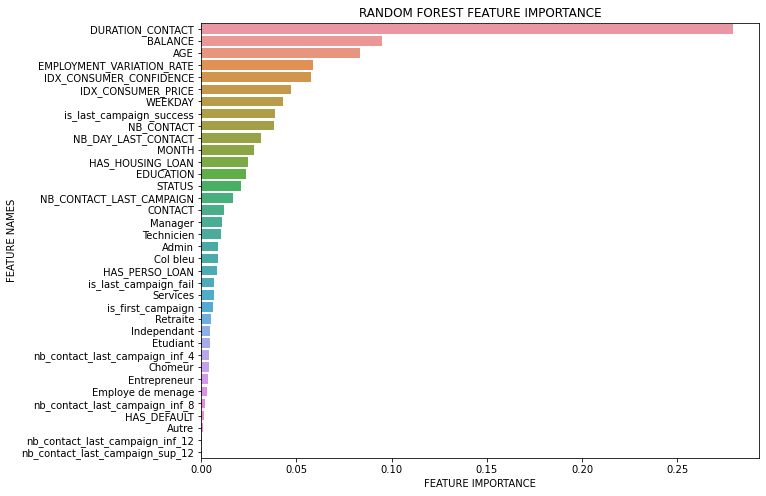

In [49]:
rf = Pipeline(steps=[('preprocessor' , preprocessor),
                      ('rf', RandomForestClassifier(criterion='gini', bootstrap=True, max_features='auto',
                                                    n_estimators=100, max_depth=None, min_samples_split=2, 
                                                    min_samples_leaf=1))])

rff = rf.fit(X_train,y_train)
plot_feature_importance(rff[1].feature_importances_,stg.FINAL_COLUMNS,'RANDOM FOREST ')

## GradientBoosting Classifier

       MONTH  WEEKDAY  is_first_campaign  nb_contact_last_campaign_inf_4  \
11215      6        4                  1                               0   
31128      4        3                  1                               0   
28041      2        0                  1                               0   

       nb_contact_last_campaign_inf_8  nb_contact_last_campaign_inf_12  \
11215                               0                                0   
31128                               0                                0   
28041                               0                                0   

       nb_contact_last_campaign_sup_12  
11215                                0  
31128                                0  
28041                                0  


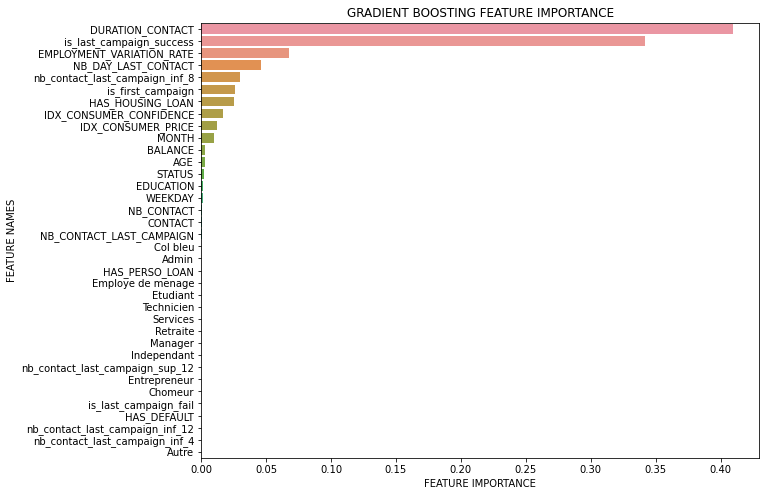

In [52]:
gbc = Pipeline(steps=[('preprocessor' , preprocessor),
                      ('gbc', GradientBoostingClassifier(n_estimators=100, loss='deviance',learning_rate=1,
                                                         max_depth=1, max_features='sqrt', random_state=10))])

gbc = gbc.fit(X_train,y_train)
plot_feature_importance(gbc[1].feature_importances_,stg.FINAL_COLUMNS,'GRADIENT BOOSTING ')

## AdaBoost Classifier

       MONTH  WEEKDAY  is_first_campaign  nb_contact_last_campaign_inf_4  \
11215      6        4                  1                               0   
31128      4        3                  1                               0   
28041      2        0                  1                               0   

       nb_contact_last_campaign_inf_8  nb_contact_last_campaign_inf_12  \
11215                               0                                0   
31128                               0                                0   
28041                               0                                0   

       nb_contact_last_campaign_sup_12  
11215                                0  
31128                                0  
28041                                0  


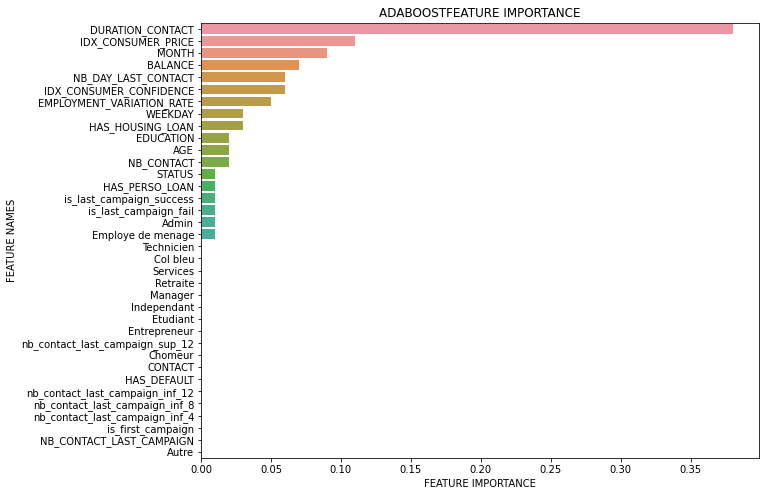

In [53]:
abc = Pipeline(steps=[('preprocessor' , preprocessor),
                      ('abc', AdaBoostClassifier(n_estimators=100, learning_rate=1,
                                                 random_state=10))])

abc = abc.fit(X_train,y_train)
plot_feature_importance(abc[1].feature_importances_,stg.FINAL_COLUMNS,'ADABOOST')